In [1]:
import pandas as pd
import numpy as np
import os
import re
import pickle
import matplotlib.pyplot as plt
import random
import math
from tqdm import tqdm

## Cargamos y limpiamos los datos

In [5]:
# read data from the csv file (from the location it is stored)
df = pd.read_csv('./wikihowSep.csv')
df = df.astype(str)
rows, columns = df.shape

In [76]:
clean_data = dict()
split_reg = re.compile("[-/\s]+")

# go overall the articles in the data file
for row in tqdm(range(rows)):
    abstract = df.iloc[row]['headline']      # headline is the column representing the summary sentences
    article = df.iloc[row]['text']           # text is the column representing the article

    #  a threshold is used to remove short articles with long summaries as well as articles with no summary
    if len(abstract) < (0.75*len(article)):
        
        # titles are cleaned from non-alphanumeric charachters
        title = df.iloc[row]['title']
        title = "".join(x for x in title if x.isalnum())
        if len(title) == 0:
            continue
        
        # clean abstract
        abstract = abstract.replace(".,",".") # remove extra commas in abstracts
        abstract = split_reg.split(abstract)
        abstract = [x for x in abstract if len(x) > 0]
        if len(abstract) == 0:
            continue
        
        # clean article
        article = re.sub(r'[.]+[\n]+[,]',".\n", article) # remove extra commas in articles
        article = article.replace(".,",".")
        article = split_reg.split(article)
        article = [x for x in article if len(x) > 0]
        if len(article) == 0:
            continue
        
        clean_data[title] = dict(
            abstract=abstract,
            article=article,
        )

100%|██████████| 1585695/1585695 [07:00<00:00, 3771.43it/s]


In [77]:
with open('./clean_data.pkl', 'wb') as f:
    pickle.dump(clean_data, f)

In [78]:
!du -h clean_data.pkl

211M	clean_data.pkl


## Dividimos datos en train / dev / test

In [1]:
def bucket_index(x, threholds):
    for i, t in enumerate(threholds):
        if x <= t:
            return i
    return len(threholds)

def split_dataset(data, dev_frac=0.03, test_frac=0.03, length_percentiles=(0.5, 0.7, 0.9), first_k=None):
    
    if first_k is not None and first_k < len(data):
        pairs = [(k,len(v['article'])) for k,v in data.items()]
        pairs.sort(key=lambda p:p[1])
        pairs = pairs[:first_k]
        titles = [p[0] for p in pairs]
        article_lengths = [p[1] for p in pairs]    
    else:        
        titles = list(data.keys())        
        article_lengths = [len(x['article']) for x in data.values()]
        
    thresholds = np.percentile(article_lengths, length_percentiles)    
    buckets = [[] for _ in range(len(thresholds) + 1)]
    for i, length in enumerate(article_lengths):
        buckets[bucket_index(length, thresholds)].append(i)
    
    train_titles = []
    dev_titles = []
    test_titles = []
    
    for bucket in buckets:
        bsize = len(bucket)
        if bsize == 0:
            continue
        random.shuffle(bucket)
        n_dev = math.ceil(bsize * dev_frac)
        n_test = math.ceil(bsize * test_frac)
        n_train = bsize - n_dev - n_test
        assert n_dev > 0
        assert n_test > 0
        assert n_train > 0
        offset = 0
        for i in range(offset, offset + n_train):
            train_titles.append(titles[bucket[i]])
        offset += n_train
        for i in range(offset, offset + n_dev):
            dev_titles.append(titles[bucket[i]])
        offset += n_dev
        for i in range(offset, offset + n_test):
            test_titles.append(titles[bucket[i]])
    
    assert len(train_titles) + len(dev_titles) + len(test_titles) == len(titles)
    return train_titles, dev_titles, test_titles

def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)
    
def save_object_as_pickle(titles, name):
    path = './%s' % name
    with open(path, 'wb') as f:
        pickle.dump(titles, f)
        print('successfully saved to %s' % path)

def update_chars_vocab(vocab, data, titles):
    for title in titles:
        for k in ('abstract', 'article'):
            for word in data[title][k]:
                vocab.update(c for c in word)
                
def get_id2char_char2id(data, train_titles, dev_titles, test_titles):
    chars_vocab = set()
    for titles in (train_titles, dev_titles, test_titles):
        update_chars_vocab(chars_vocab, data, titles)
    id2char = ['<PAD>']
    id2char.extend(chars_vocab)
    char2id = {c:i for i,c in enumerate(id2char)}
    return id2char, char2id

In [4]:
clean_data = load_pickle('./clean_data.pkl')

### 1) train, dev y test con el dataset completo

In [4]:
all_train_titles, all_dev_titles, all_test_titles = split_dataset(
    clean_data, dev_frac=0.03, test_frac=0.03, length_percentiles=(0.5, 0.7, 0.9))

In [8]:
all_id2char, all_char2id = get_id2char_char2id(clean_data, all_train_titles, all_dev_titles, all_test_titles)

In [ ]:
save_object_as_pickle(all_train_titles, 'all_train_titles.pkl')
save_object_as_pickle(all_dev_titles, 'all_dev_titles.pkl')
save_object_as_pickle(all_test_titles, 'all_test_titles.pkl')
save_object_as_pickle(all_char2id, 'all_char2id.pkl')
save_object_as_pickle(all_id2char, 'all_id2char.pkl')

### 2) train, dev y test con una versión miniatura del dataset

In [5]:
mini_train_titles, mini_dev_titles, mini_test_titles = split_dataset(
    clean_data, dev_frac=0.03, test_frac=0.03, length_percentiles=(0.5, 0.7, 0.9), first_k=50000)

In [6]:
mini_id2char, mini_char2id = get_id2char_char2id(clean_data, mini_train_titles, mini_dev_titles, mini_test_titles)

In [7]:
save_object_as_pickle(mini_train_titles, 'mini_train_titles.pkl')
save_object_as_pickle(mini_dev_titles, 'mini_dev_titles.pkl')
save_object_as_pickle(mini_test_titles, 'mini_test_titles.pkl')
save_object_as_pickle(mini_char2id, 'mini_char2id.pkl')
save_object_as_pickle(mini_id2char, 'mini_id2char.pkl')

successfully saved to ./mini_train_titles.pkl
successfully saved to ./mini_dev_titles.pkl
successfully saved to ./mini_test_titles.pkl
successfully saved to ./mini_char2id.pkl
successfully saved to ./mini_id2char.pkl


# Actividad 1: diseño del modelo

El código a continuación es un poco largo, pero en resumen el modelo consiste en lo siguiente:

Para esta tarea me propuse como desafío 2 cosas: 1) Usar Universal Transformers (https://arxiv.org/abs/1807.03819) y 2) Usar _character-level_ embeddings. Mi motivación es que siento que un modelo de NLP robusto debería ser capaz de entender caracteres y ser capaz de identificar palabras a partir de sus caracteres, y por otro lado el Transformer es la base de varios modelos estado del arte en NLP. Para esta tarea el modelo que se me ocurrió se puede apreciar en parte en esta pregunta que hice en Data Science Stackexchange: https://datascience.stackexchange.com/questions/53814/pytorch-how-to-implement-nested-transformers-a-character-level-transformer-for. En resumen:

Para el Encoder uso 2 (universal) transformers. Pimero un _character transformer_ procesa los embeddings de los caracteres de las palabras y luego con un par de capas extras se genera un pooling de los embeddings de caracteres transformados produciendo un word embedding inicial por cada palabra. Luego estos word embeddings iniciales son procesados por el segundo transformer (el cual ya opera a nivel de palabras). Como resultado final por parte del Encoder se obtiene word embeddings contextuales de las palabras del texto de origen.

Para el Decoder al principio pensé en seguir con la idea de usar transformers, pero después me dí cuenta que computacionalmente el decoder de un Transformer es bastante caro, por lo que al final opté por una solución intermedia. En el decoder uso el **character transformer** para generar word embeddings iniciales, pero después encima de eso corro una LSTM (no uso el word transformer), muy parecido al decoder que usamos en la Tarea 3. Un detalle sí (que complicó la implementación bastante) es que como me propuse trabajar a nivel de caracteres, en cada iteración de la LSTM el decoder tiene que predecir **todos** los caracteres de la siguiente palabra. Para lograr esto, lo que se me ocurrió fue hacer que la LSTM en cada paso genere un vector que represente qué palabra quiere generar, y luego un módulo _WordCharsPredictor_ tendría la función de aprender a mapear un par (vector de lstm, positional enconding) a un caracter, es decir, dado el vector de palabra que quiero escribir y un vector de posición, dame el caracter que va en esa posición en la palabra que quiero escribir. Lo sé, me compliqué la vida innecesariamente, pero quería ver si podía funcionar.

Otro detalle estaba en determinar dos cosas: cuándo una palabra termina (último caracter de la palabra) y cuándo una oración termina (última palabra de la oración). Para lograr ambos objetivos, en lugar de usar los típicos tokens de fin de secuencia, me planteé la posibilidad de hacerlo distinto. Generé 2 tareas auxiliares: 1) clasificar un caracter como último/no último y 2) clasificar una palabra como última/no última. De esta manera el modelo resultante se entrena con multitask learning.

In [2]:
import torch
import torch.nn as nn
import math

In [3]:
def scaled_dot_attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
#     assert d_k > 0
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = torch.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value)

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super().__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_h = d_model // h
        self.h = h
        self.dropout = nn.Dropout(dropout)
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.o_linear = nn.Linear(d_model, d_model)
        
    def forward(self, query, key, value, mask=None):
        
#         assert query.shape == key.shape
#         assert query.shape == value.shape
#         assert query.size(-1) == self.h * self.d_h
        
        sequence_size = query.size(-2)
        if mask is not None:
            mask = mask.view(-1, 1, 1, sequence_size)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k
        new_shape = (-1, sequence_size, self.h, self.d_h)
        proj_query = self.q_linear(query).view(new_shape).transpose(1,2)
        proj_key =   self.q_linear(key).view(new_shape).transpose(1,2)
        proj_value = self.q_linear(value).view(new_shape).transpose(1,2)
        
        # 2) Apply attention on all the projected vectors in batch. 
        x = scaled_dot_attention(proj_query, proj_key, proj_value,
                                 mask=mask,
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(value.shape)
        return self.o_linear(x)

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(torch.relu(self.w_1(x))))

class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super().__init__()
        self.norm = nn.LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

class RecurrentLayer(nn.Module):
    """
    Encoder is made up of self-attn and feed forward (defined below)
    """
    def __init__(self, feature_size, self_attn, feed_forward, dropout):
        super().__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayers = nn.ModuleList((
            SublayerConnection(feature_size, dropout),
            SublayerConnection(feature_size, dropout),
        ))
        self.feature_size = feature_size

    def forward(self, x, mask):
        x = self.sublayers[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayers[1](x, self.feed_forward)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model, dtype=torch.float32)
        position = torch.arange(0., max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:, :x.size(-2)]
        return self.dropout(x)
    
class UniversalTransformer(nn.Module):
    def __init__(
        self,
        d_model,
        d_ff,
        n_heads,
        dropout,
        max_sequence_len=5000,
    ):
        super().__init__()
        self.recurrent_layer = RecurrentLayer(
            feature_size = d_model,
            self_attn = MultiHeadedAttention(n_heads, d_model, dropout),
            feed_forward = PositionwiseFeedForward(d_model, d_ff, dropout),
            dropout = dropout,
        )
        self.norm = nn.LayerNorm(d_model)
        self.pos_enc = PositionalEncoding(d_model, dropout, max_sequence_len)
        
    def forward(self, embedded_sequences, mask=None, steps=3):
#         print('Universal Transformer:: embedded_sequences.shape = ', embedded_sequences.shape)
        X = self.pos_enc(embedded_sequences)
        for _ in range(steps):
            X = self.recurrent_layer(X, mask)
        return self.norm(X)
    
class Characters2Words(nn.Module):
    def __init__(self, char_emb_size, word_emb_size):
        super().__init__()
        self.w1 = nn.Linear(char_emb_size, word_emb_size)
        self.w2 = nn.Linear(word_emb_size, word_emb_size)
        self.norm = nn.LayerNorm(word_emb_size)
    def forward(self, char_embeddings, mask):
        masked_x = self.w1(char_embeddings) * mask.unsqueeze(-1)
        # assert not torch.isnan(masked_x).any()
        return self.w2(self.norm(masked_x.sum(-2)))

class EncoderModule(nn.Module):
    def __init__(
        self,
        char_embedding_table,
        char_transformer,
        char_recurrent_steps,
        chars2words,
        word_transformer,
        word_recurrent_steps,
    ):
        super().__init__()
        self.char_embedding_table = char_embedding_table
        self.char_transformer = char_transformer
        self.char_steps = char_recurrent_steps        
        self.chars2words = chars2words
        self.word_transformer = word_transformer
        self.word_steps = word_recurrent_steps
        
    def forward(
        self,
        src_sentences,
        src_sentence_char_mask,
        src_sentence_word_mask,
    ):
        # --- char-level embeddings ----
        char_embeddings = self.char_embedding_table(src_sentences)
        transf_char_embeddings = self.char_transformer(
            char_embeddings,
            src_sentence_char_mask,
            self.char_steps,        
        )
        
        # --- word-level embeddings ----
        word_embeddings = self.chars2words(
            transf_char_embeddings,
            src_sentence_char_mask.float(),
        )
        transf_word_embeddings = self.word_transformer(
            word_embeddings,
            src_sentence_word_mask,
            self.word_steps,
        )        
        return transf_word_embeddings
        
        
class WordCharsPredictor(nn.Module):
    
    def __init__(
        self,
        word_emb_size,
        hidden_size,
        dst_char_vocab_size,
        dropout,
    ):
        super().__init__()
        self.word_emb_size = word_emb_size
        self.hidden_size = hidden_size
        self.pos_enc = PositionalEncoding(hidden_size, dropout, max_len=500)
        self.W_h = nn.Linear(word_emb_size, hidden_size)
        self.W_vocab = nn.Linear(hidden_size, dst_char_vocab_size)
        self.W_islast = nn.Linear(hidden_size, 1)
        
    def forward(
        self,
        word_embedding,
        max_word_len,
    ):
        batch_size = word_embedding.size(0)
#         assert word_embedding.shape == (batch_size, self.word_emb_size)
        expand_shape = (batch_size, max_word_len, self.hidden_size)        
        x = self.W_h(word_embedding)
        x = self.pos_enc(x.unsqueeze(1).expand(expand_shape))
#         assert x.shape == expand_shape
        return (
            self.W_vocab(x), # logits over char vocabulary
            self.W_islast(x), # binary logit -> whether each char is the last char of the word
        )
        
        
class DecoderModule(nn.Module):
    
    def __init__(
        self,
        char_transformer,
        word_transformer,
        hidden_size,
        word_embedding_size,
        char_embedding_table,
        char_recurrent_steps,
        chars2words,
        dst_char_vocab_size,
        char_predictor_hidden_size,
        dropout,
        id2char,
    ):
        super().__init__()
        self.char_transformer = char_transformer
        self.word_transformer = word_transformer
        self.y0 = nn.Parameter(torch.rand(word_embedding_size))        
        self.hidden_size = hidden_size
        self.word_embedding_size = word_embedding_size
        self.dst_char_vocab_size = dst_char_vocab_size
        self.W_init = nn.Linear(word_embedding_size, hidden_size)
        self.norm_init = nn.LayerNorm(hidden_size)
        self.W_h = nn.Linear(hidden_size, hidden_size)
        self.W_c = nn.Linear(hidden_size, hidden_size)
        self.char_embedding_table = char_embedding_table
        self.char_steps = char_recurrent_steps
        self.chars2words = chars2words
        self.lstm_cell = nn.LSTMCell(input_size=word_embedding_size+hidden_size,
                                     hidden_size=hidden_size,
                                     bias=True)
        self.W_attn = nn.Linear(hidden_size, hidden_size)
        self.W_u = nn.Linear(2 * hidden_size, hidden_size)
        self.W_islast = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout)        
        self.word_chars_pred = WordCharsPredictor(word_embedding_size,
                                                  char_predictor_hidden_size,
                                                  dst_char_vocab_size,
                                                  dropout)
        self.id2char = id2char
    
    def forward(
        self,
        src_sentence_final_word_embeddings,
        src_sentence_word_mask,
        dst_sentences,
        dst_sentence_char_mask,
        dst_sentence_word_mask,
    ):
        
#         assert (src_sentence_word_mask.dtype == torch.uint8)
        src_softmax_mask = (src_sentence_word_mask == 0) # for softmax using .masked_fill(mask, -1e9)
        src_mult_mask = src_sentence_word_mask.float() # for elementwise multiplication by 0
        
        batch_size = dst_sentences.size(0)
        dst_max_sentlen = dst_sentences.size(1)
        dst_max_wordlen = dst_sentences.size(2)
    
        y = self.y0.expand(batch_size, -1)
        o = torch.zeros(batch_size, self.hidden_size).to(DEVICE)
        all_enc_hidden_states, (h, c) = self.project_src_words_and_init_hidden_and_cell(
            src_sentence_final_word_embeddings,
            src_mult_mask,
        )
        
        dst_word_embeddings = self.compute_dst_word_embeddings(
            dst_sentences,
            dst_sentence_char_mask,
        )
        
        dst_word_embeddings = dst_word_embeddings.transpose(0, 1)
        
#         assert dst_word_embeddings.shape == (dst_max_sentlen, batch_size, self.word_embedding_size)
        
        output_word_islast_logits = []
        output_char_class_logits = []
        output_char_islast_logits = []
        output_translations = ['' for _ in range(batch_size)]
        
        for t in range(dst_max_sentlen):
            y_bar = torch.cat((y,o),1)
#             assert y_bar.shape == (batch_size, self.word_embedding_size + self.hidden_size)
#             assert h.shape == (batch_size, self.hidden_size)
#             assert c.shape == (batch_size, self.hidden_size)
            h, c = self.lstm_cell(y_bar, (h, c))
            e = (all_enc_hidden_states * self.W_attn(h).unsqueeze(1)).sum(-1)
            e.masked_fill(src_softmax_mask, -1e9)
            att = torch.softmax(e,-1)            
            a = (all_enc_hidden_states * att.unsqueeze(2)).sum(1)
#             assert a.shape == (batch_size, self.hidden_size)
            u = torch.cat((a,h),1)
#             assert u.shape == (batch_size, 2 * self.hidden_size)
            v = self.W_u(u)
            o = self.dropout(torch.tanh(v))
#             assert o.shape == (batch_size, self.hidden_size)
            
            word_islast_logits = self.W_islast(o)
            char_class_logits, char_islast_logits = self.word_chars_pred(o, dst_max_wordlen)
            
            char_islast = torch.sigmoid(char_islast_logits).squeeze(-1) > 0.5
            char_class = torch.softmax(char_class_logits, -1).argmax(-1)
            
#             try:
#                 assert char_islast.shape == (batch_size, dst_max_wordlen)
#                 assert char_class.shape == (batch_size, dst_max_wordlen)
#             except AssertionError:
#                 print('dst_sentences.shape = ', dst_sentences.shape)
#                 print('batch_size = ', batch_size)
#                 print('dst_max_wordlen = ', dst_max_wordlen)
#                 print('char_islast_logits.shape = ', char_islast_logits.shape)
#                 print('char_islast.shape = ', char_islast.shape)
#                 print('char_class_logits.shape = ', char_class_logits.shape)
#                 print('char_class.shape = ', char_class.shape)
#                 raise
                
            for i in range(batch_size):
                if dst_sentence_word_mask[i][t]:
                    if t > 0:
                        output_translations[i] += ' '
                    for j in range(dst_max_wordlen):
                        output_translations[i] += self.id2char[char_class[i][j]]
                        if char_islast[i][j]:
                            break
            
            output_word_islast_logits.append(word_islast_logits)
            output_char_islast_logits.append(char_islast_logits)
            output_char_class_logits.append(char_class_logits)
            
            y = dst_word_embeddings[t]
        
        output_char_class_logits = torch.stack(output_char_class_logits, 1)
        output_char_islast_logits = torch.stack(output_char_islast_logits, 1)
        output_word_islast_logits = torch.stack(output_word_islast_logits, 1)
        
#         assert output_char_class_logits.shape == (batch_size, dst_max_sentlen, dst_max_wordlen, self.dst_char_vocab_size)
#         assert output_char_islast_logits.shape == (batch_size, dst_max_sentlen, dst_max_wordlen, 1)
#         assert output_word_islast_logits.shape == (batch_size, dst_max_sentlen, 1)        
        return (
            output_char_class_logits,
            output_char_islast_logits,
            output_word_islast_logits,
            output_translations,
        )
    
    def eval_forward(
        self,
        src_sentence_final_word_embeddings,
        src_sentence_word_mask,
        dst_max_sentence_len=100,
        dst_max_word_len=30,
    ):
        
#         assert (src_sentence_word_mask.dtype == torch.uint8)        
        src_softmax_mask = (src_sentence_word_mask == 0) # for softmax using .masked_fill(mask, -1e9)
        src_mult_mask = src_sentence_word_mask.float() # for elementwise multiplication by 0
        
        batch_size = src_sentence_final_word_embeddings.size(0)
    
        y = self.y0.expand(batch_size, -1)
        o = torch.zeros(batch_size, self.hidden_size).to(DEVICE)
        all_enc_hidden_states, (h, c) = self.project_src_words_and_init_hidden_and_cell(
            src_sentence_final_word_embeddings,
            src_mult_mask,
        )
        
        output_word_islast_logits = []
        output_char_class_logits = []
        output_char_islast_logits = []
        output_translations = ['' for _ in range(batch_size)]
        done = np.zeros(batch_size, dtype=bool)
        char_mask = torch.empty(batch_size, dst_max_word_len, dtype=torch.uint8, device=DEVICE)
        
        for t in range(dst_max_sentence_len):
            y_bar = torch.cat((y,o),1)
#             assert y_bar.shape == (batch_size, self.word_embedding_size + self.hidden_size)
#             assert h.shape == (batch_size, self.hidden_size)
#             assert c.shape == (batch_size, self.hidden_size)
            h, c = self.lstm_cell(y_bar, (h, c))
            e = (all_enc_hidden_states * self.W_attn(h).unsqueeze(1)).sum(-1)
            e.masked_fill(src_softmax_mask, -1e9)
            att = torch.softmax(e,-1)            
            a = (all_enc_hidden_states * att.unsqueeze(2)).sum(1)
#             assert a.shape == (batch_size, self.hidden_size)
            u = torch.cat((a,h),1)
#             assert u.shape == (batch_size, 2 * self.hidden_size)
            v = self.W_u(u)
            o = self.dropout(torch.tanh(v))
#             assert o.shape == (batch_size, self.hidden_size)
            
            word_islast_logits = self.W_islast(o)
            char_class_logits, char_islast_logits = self.word_chars_pred(o, dst_max_word_len)
            
            word_islast = torch.sigmoid(word_islast_logits).squeeze(-1) > 0.5
            char_islast = torch.sigmoid(char_islast_logits).squeeze(-1) > 0.5
            char_class = torch.softmax(char_class_logits, -1).argmax(-1)
#             assert word_islast.shape == (batch_size,)
#             assert char_islast.shape == (batch_size, dst_max_word_len)
#             assert char_class.shape == (batch_size, dst_max_word_len)
            
            char_mask.fill_(0)
            for i in range(batch_size):
                if done[i]:
                    continue
                done[i] = word_islast[i]
                if t > 0:
                    output_translations[i] += ' '
                for j in range(dst_max_word_len):
                    char_mask[i][j] = 1
                    output_translations[i] += self.id2char[char_class[i][j]]
                    if char_islast[i][j]:
                        break
                
            y = self.compute_dst_word_embeddings(char_class, char_mask)
#             assert y.shape == (batch_size, self.word_embedding_size)
            
            output_word_islast_logits.append(word_islast_logits)
            output_char_islast_logits.append(char_islast_logits)
            output_char_class_logits.append(char_class_logits)
        
        output_char_class_logits = torch.stack(output_char_class_logits, 1)
        output_char_islast_logits = torch.stack(output_char_islast_logits, 1)
        output_word_islast_logits = torch.stack(output_word_islast_logits, 1)
#         assert output_char_class_logits.shape == (batch_size, dst_max_sentence_len, dst_max_word_len, self.dst_char_vocab_size)
#         assert output_char_islast_logits.shape == (batch_size, dst_max_sentence_len, dst_max_word_len, 1)
#         assert output_word_islast_logits.shape == (batch_size, dst_max_sentence_len, 1)        
        return (
            output_char_class_logits,
            output_char_islast_logits,
            output_word_islast_logits,
            output_translations,
        )
    
    def project_src_words_and_init_hidden_and_cell(
        self,
        src_sentence_word_embeddings,
        src_sentence_word_mask,
    ):
        src_proj = self.W_init(src_sentence_word_embeddings)
        x = (src_proj * src_sentence_word_mask.unsqueeze(-1)).sum(-2)
        x = self.norm_init(x)
        h0 = self.W_h(x)
        c0 = self.W_c(x)
        return src_proj, (h0, c0)
    
    def compute_dst_word_embeddings(
        self,
        dst_sentences,
        dst_sentence_char_mask,
    ):
        # --- char-level embeddings ----
        char_embeddings = self.char_embedding_table(dst_sentences)
        transf_char_embeddings = self.char_transformer(
            char_embeddings,
            dst_sentence_char_mask,
            self.char_steps,  
        )        
        # --- word-level embeddings ----
        word_embeddings = self.chars2words(
            transf_char_embeddings,
            dst_sentence_char_mask.float(),
        )
        return word_embeddings


def compute_mask(sequence_lengths):
    maxlen = sequence_lengths.max()
    mask = torch.arange(maxlen, device=DEVICE)\
                .expand((*sequence_lengths.shape, maxlen))\
                < sequence_lengths.unsqueeze(-1)
    return mask    

class NeuralMachineTranslator(nn.Module):
    def __init__(
        self,
        char_vocab_size,
        char_embedding_size,
        word_embedding_size,
        char_transformer_recurrent_steps,
        char_transformer_heads,
        word_transformer_recurrent_steps,
        word_transformer_heads,
        dec_hidden_size,
        dec_char_pred_hidden_size,
        id2char,
        dropout,
    ):
        super().__init__()
        
        char_embedding_table = nn.Embedding(
            num_embeddings=char_vocab_size,
            embedding_dim=char_embedding_size,
            padding_idx=0,
        )
        
        char_transformer = UniversalTransformer(
            d_model=char_embedding_size,
            d_ff=char_embedding_size*2,
            n_heads=char_transformer_heads,
            dropout=dropout,
        )
        char_transformer.name = 'char transformer'
        
        chars2words = Characters2Words(
            char_emb_size = char_embedding_size,
            word_emb_size = word_embedding_size,
        )
        
        word_transformer = UniversalTransformer(
            d_model=word_embedding_size,
            d_ff=word_embedding_size*2,
            n_heads=word_transformer_heads,
            dropout=dropout,
        )
        word_transformer.name = 'word transformer'
        
        self.encoder_module = EncoderModule(
            char_embedding_table,
            char_transformer,
            char_transformer_recurrent_steps,
            chars2words,
            word_transformer,
            word_transformer_recurrent_steps,
        )
        
        self.decoder_module = DecoderModule(
            char_transformer=char_transformer,
            word_transformer=word_transformer,
            hidden_size=dec_hidden_size,
            word_embedding_size=word_embedding_size,
            char_embedding_table=char_embedding_table,
            char_recurrent_steps=char_transformer_recurrent_steps,
            chars2words=chars2words,
            dst_char_vocab_size=char_vocab_size,
            char_predictor_hidden_size=dec_char_pred_hidden_size,
            dropout=dropout,
            id2char=id2char,
        )
    
    def forward(
        self,
        src_sentences,
        src_sentence_word_mask,
        src_sentence_char_mask,
        dst_sentences,
        dst_sentence_word_mask,
        dst_sentence_char_mask,
    ):
#         assert len(src_sentences.shape) == 3 # batch_size x words x chars
#         assert len(src_sentence_word_mask.shape) == 2 # batch_size x words 
#         assert len(src_sentence_char_mask.shape) == 3 # batch_size x words x chars
        
#         assert len(dst_sentences.shape) == 3 # batch_size x words x chars
#         assert len(dst_sentence_word_mask.shape) == 2 # batch_size x words
#         assert len(dst_sentence_char_mask.shape) == 3 # batch_size x words x chars
        
        # ---- encoding -----
        src_final_word_embeddings =\
        self.encoder_module(
            src_sentences,
            src_sentence_char_mask,
            src_sentence_word_mask,
        )
        
        # ---- decoding -----
        return self.decoder_module(
            src_final_word_embeddings,
            src_sentence_word_mask,
            dst_sentences,
            dst_sentence_char_mask,
            dst_sentence_word_mask,
        )
    
    def eval_forward(
        self,
        src_sentences,
        src_sentence_word_mask,
        src_sentence_char_mask,
        dst_max_sentence_len,
        dst_max_word_len,
    ):
#         assert len(src_sentences.shape) == 3 # batch_size x words x chars
#         assert len(src_sentence_word_mask.shape) == 2 # batch_size x words
#         assert len(src_sentence_char_mask.shape) == 3 # batch_size x words x chars
        
        # ---- encoding -----
        src_final_word_embeddings =\
        self.encoder_module(
            src_sentences,
            src_sentence_char_mask,
            src_sentence_word_mask,
        )
        
        # ---- decoding -----        
        return self.decoder_module.eval_forward(
            src_final_word_embeddings,
            src_sentence_word_mask,
            dst_max_sentence_len,
            dst_max_word_len,
        )

## Generación de mini-batches

In [4]:
import random

def compute_batch(
    data, titles, char2id, batch_indices,
    src_max_wordlen, src_max_sentlen, dst_max_wordlen, dst_max_sentlen
):
    batch_size = len(batch_indices)
    assert batch_size > 0
    
    src_sentences = np.zeros((batch_size, src_max_sentlen, src_max_wordlen), dtype=int)
    src_sentence_word_lens = np.zeros((batch_size, src_max_sentlen), dtype=int)
    src_sentence_lens = np.empty((batch_size,), dtype=int)
    
    dst_sentences = np.zeros((batch_size, dst_max_sentlen, dst_max_wordlen), dtype=int)
    dst_sentence_word_lens = np.zeros((batch_size, dst_max_sentlen), dtype=int)
    dst_sentence_lens = np.empty((batch_size,), dtype=int)
    dst_sentence_word_islast = np.zeros((batch_size, dst_max_sentlen), dtype=np.uint8)
    dst_sentence_char_islast = np.zeros((batch_size, dst_max_sentlen, dst_max_wordlen), dtype=np.uint8)
    dst_translations = [" ".join(data[titles[i]]['abstract']) for i in batch_indices]
    
    for i, idx in enumerate(batch_indices):
        src = data[titles[idx]]['article']
        src_sentence_lens[i] = len(src)
        for j, word in enumerate(src):
            src_sentence_word_lens[i][j] = len(word)
            for k, char in enumerate(word):
                src_sentences[i][j][k] = char2id[char]

    for i, idx in enumerate(batch_indices):
        dst = data[titles[idx]]['abstract']
        dst_sentence_lens[i] = len(dst)
        for j, word in enumerate(dst):
            dst_sentence_word_lens[i][j] = len(word)
            dst_sentence_word_islast[i][j] = (j == len(dst)-1)
            for k, char in enumerate(word):
                dst_sentences[i][j][k] = char2id[char]
                dst_sentence_char_islast[i][j][k] = (k == len(word)-1)
    
    return dict(
        indices =                  batch_indices.copy(),
        src_sentences =            src_sentences,
        src_sentence_lens =        src_sentence_lens,
        src_sentence_word_lens =   src_sentence_word_lens,
        dst_sentences =            dst_sentences,
        dst_sentence_lens =        dst_sentence_lens,
        dst_sentence_word_lens =   dst_sentence_word_lens,
        dst_sentence_char_islast = dst_sentence_char_islast,
        dst_sentence_word_islast = dst_sentence_word_islast,
        dst_translations         = dst_translations,
    )

def precompute_batches(data, titles, char2id, char_emb_size, word_emb_size, max_batch_mem):
    n = len(titles)
    indices = list(range(n))
    random.shuffle(indices)
    indices.sort(key=lambda i:len(data[titles[i]]['article']))
    
    src_max_wordlen = 0
    src_max_sentlen = 0
    dst_max_wordlen = 0
    dst_max_sentlen = 0
    
    batches = []
    batch_indices = []    
    
    for i in tqdm(indices):
        
        src = data[titles[i]]['article']
        dst = data[titles[i]]['abstract']        
        
        inst_src_max_wordlen = max(len(w) for w in src)
        inst_src_max_sentlen = len(src)
        inst_dst_max_wordlen = max(len(w) for w in dst)
        inst_dst_max_sentlen = len(dst)
        
        nxt_src_max_wordlen = max(src_max_wordlen, inst_src_max_wordlen)
        nxt_src_max_sentlen = max(src_max_sentlen, inst_src_max_sentlen)
        nxt_dst_max_wordlen = max(dst_max_wordlen, inst_dst_max_wordlen)
        nxt_dst_max_sentlen = max(dst_max_sentlen, inst_dst_max_sentlen)
        
        batch_mem = ((nxt_src_max_sentlen * nxt_src_max_wordlen**2 * char_emb_size) +\
                      (nxt_src_max_sentlen ** 2 * word_emb_size) +\
                     (nxt_dst_max_sentlen * nxt_dst_max_wordlen**2 * char_emb_size) +\
                      (nxt_dst_max_sentlen ** 2 * word_emb_size)) *\
                     (len(batch_indices)+1)
        
        if batch_mem <= max_batch_mem:
            batch_indices.append(i)
            src_max_wordlen = nxt_src_max_wordlen
            src_max_sentlen = nxt_src_max_sentlen
            dst_max_wordlen = nxt_dst_max_wordlen
            dst_max_sentlen = nxt_dst_max_sentlen
        else:
            assert len(batch_indices) > 0            
            batches.append(compute_batch(data, titles, char2id, batch_indices,
                                         src_max_wordlen, src_max_sentlen,
                                         dst_max_wordlen, dst_max_sentlen))
            batch_indices.clear()
            batch_indices.append(i)
            src_max_wordlen = inst_src_max_wordlen
            src_max_sentlen = inst_src_max_sentlen
            dst_max_wordlen = inst_dst_max_wordlen
            dst_max_sentlen = inst_dst_max_sentlen
    
    batches.append(compute_batch(data, titles, char2id, batch_indices,
                                         src_max_wordlen, src_max_sentlen,
                                         dst_max_wordlen, dst_max_sentlen))
    
    return batches

## Multi-task loss criterion

In [5]:
class NMT_MultitaskLossCriterion:
    def __init__(
        self,
        char_islast_pos_weight = 5.,
        word_islast_pos_weight = 20.,
        eps=1e-8,
        w_char_class = 0.6,
        w_char_islast = 0.2,
        w_word_islast = 0.2,
    ):
        # sanity check and normalize task weights
        w_sum = w_char_class + w_char_islast + w_word_islast 
        assert w_sum > 0
        assert w_char_class >= 0
        assert w_char_islast >= 0
        assert w_word_islast >= 0
        w_char_class /= w_sum
        w_char_islast /= w_sum
        w_word_islast /= w_sum
        
        char_islast_pos_weight = torch.empty(1).fill_(char_islast_pos_weight).to(DEVICE)
        word_islast_pos_weight = torch.empty(1).fill_(word_islast_pos_weight).to(DEVICE)
        self.w_char_class = w_char_class
        self.w_char_islast = w_char_islast
        self.w_word_islast = w_word_islast
        self.criterion_char_class = nn.CrossEntropyLoss(ignore_index=0)
        self.criterion_char_islast = nn.BCEWithLogitsLoss(pos_weight=char_islast_pos_weight, reduction='none')
        self.criterion_word_islast = nn.BCEWithLogitsLoss(pos_weight=word_islast_pos_weight, reduction='none')
        self.eps = eps
    
    def __call__(
        self,
        logits_char_class,
        logits_char_islast,
        logits_word_islast,
        targets_char_class,
        targets_char_islast,
        targets_word_islast,
        mask_char_islast,
        mask_word_islast,
    ):
#         assert len(logits_char_class.shape) == 2
#         assert len(logits_char_islast.shape) == 1
#         assert len(logits_word_islast.shape) == 1
#         assert len(targets_char_class.shape) == 1
#         assert len(targets_char_islast.shape) == 1
#         assert len(targets_word_islast.shape) == 1
#         assert len(mask_char_islast.shape) == 1
#         assert len(mask_word_islast.shape) == 1
        
        # char class loss
        loss_char_class =  self.criterion_char_class(logits_char_class, targets_char_class)
        
        # char islast loss
        losses_char_islast = self.criterion_char_islast(logits_char_islast, targets_char_islast)
        loss_char_islast = (losses_char_islast * mask_char_islast).sum() / (mask_char_islast.sum() + self.eps)
        
        # word islast loss
        losses_word_islast = self.criterion_word_islast(logits_word_islast, targets_word_islast)
        loss_word_islast = (losses_word_islast * mask_word_islast).sum() / (mask_word_islast.sum() + self.eps)
        
        # final loss
        final_loss = self.w_char_class * loss_char_class +\
                     self.w_char_islast * loss_char_islast +\
                     self.w_word_islast * loss_word_islast
        return final_loss

# Actividades 2 y 3: entrenando y evaluando el modelo

In [6]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils import clip_grad_norm_
import pickle
import re
import matplotlib.pyplot as plt
import numpy as np
import rouge
import time
import copy
from tqdm import tqdm

In [43]:
def train_model(nmt, optimizer, criterion, scheduler, train_batches, dev_batches, epochs,
                checkpoint_path=None, starting_weights='best_dev'):
    
    since = time.time()
    
    evaluator = rouge.Rouge(metrics=['rouge-n', 'rouge-l'], max_n=2)
    
    if checkpoint_path is None:
        print('training from scratch ....')
        epoch_one = 1
        best_dev_wts = best_train_wts = copy.deepcopy(nmt.state_dict())
        best_dev_f = -1e9
        best_train_f = -1e9
        history = dict()
        for phase in ('train', 'dev'):
            history['%s_loss' % phase] = []
            history['%s_rouge1_f' % phase] = []
            history['%s_rouge2_f' % phase] = []
            history['%s_rougel_f' % phase] = []
    else:
        print('resuming training from checkpoint = %s ....' % checkpoint_path)
        checkpoint = torch.load(checkpoint_path)
        best_dev_wts = checkpoint['best_dev_wts']
        best_train_wts = checkpoint['best_train_wts']
        best_dev_f = checkpoint['best_dev_f']
        best_train_f = checkpoint['best_train_f']
        history = checkpoint['history']
        epoch_one = len(history['train_loss'])+1
        if starting_weights == 'best_dev':
            print('** using best_dev_wts (best_dev_f = 5.f)' % best_dev_f)
            nmt.load_state_dict(best_dev_wts)
        elif starting_weights == 'best_train':
            print('** using best_train_wts (best_train_f = 5.f)' % best_train_f)
            nmt.load_state_dict(best_train_wts)
        else:
            print('** using last_wts')
            nmt.load_state_dict(checkpoint['last_wts'])

    for epoch in range(epoch_one, epochs+1):
        print('\n====== [Epoch {}/{}]'.format(epoch, epochs))
        
        for phase in ('train', 'dev'):
            
            print('--------------------- %s ---------------------' % phase)
            
            if phase == 'train':
                nmt.train()
                batches = train_batches
            else:
                nmt.eval()
                batches = dev_batches

            running_loss = 0.
            running_rouge1_f = 0.
            running_rouge2_f = 0.
            running_rougel_f = 0.
            running_count = 0
            epoch_since = time.time()
                
            with torch.set_grad_enabled(phase == 'train'):                
                
                for batch_idx, batch in enumerate(batches):
                    
                    src_sentences = torch.from_numpy(batch['src_sentences']).to(DEVICE)
                    src_sentence_lengths = torch.from_numpy(batch['src_sentence_lens']).to(DEVICE)
                    src_sentence_word_lengths = torch.from_numpy(batch['src_sentence_word_lens']).to(DEVICE)

                    dst_sentences = torch.from_numpy(batch['dst_sentences']).to(DEVICE)
                    dst_sentence_lengths = torch.from_numpy(batch['dst_sentence_lens']).to(DEVICE)
                    dst_sentence_word_lengths = torch.from_numpy(batch['dst_sentence_word_lens']).to(DEVICE)

                    targets_char_islast = torch.from_numpy(batch['dst_sentence_char_islast']).to(DEVICE).view(-1)
                    targets_word_islast = torch.from_numpy(batch['dst_sentence_word_islast']).to(DEVICE).view(-1)
                    
                    src_sentence_word_mask = compute_mask(src_sentence_lengths)
                    src_sentence_char_mask = compute_mask(src_sentence_word_lengths)
                    dst_sentence_word_mask = compute_mask(dst_sentence_lengths)
                    dst_sentence_char_mask = compute_mask(dst_sentence_word_lengths)
                    
                    optimizer.zero_grad()
                    
                    # forward pass
                    if phase == 'train':
                        output_char_class_logits,\
                        output_char_islast_logits,\
                        output_word_islast_logits,\
                        output_translations = nmt(
                            src_sentences,
                            src_sentence_word_mask,
                            src_sentence_char_mask,
                            dst_sentences,
                            dst_sentence_word_mask,
                            dst_sentence_char_mask,
                        )
                    else:
                        output_char_class_logits,\
                        output_char_islast_logits,\
                        output_word_islast_logits,\
                        output_translations = nmt.eval_forward(
                            src_sentences,
                            src_sentence_word_mask,
                            src_sentence_char_mask,
                            dst_sentence_word_mask.size(-1),
                            dst_sentence_char_mask.size(-1),
                        )
                    
                    # --- loss
                    loss = criterion(
                        output_char_class_logits.view(-1, output_char_class_logits.size(-1)),
                        output_char_islast_logits.view(-1),
                        output_word_islast_logits.view(-1),
                        dst_sentences.view(-1),
                        targets_char_islast.view(-1).float(),
                        targets_word_islast.view(-1).float(),
                        dst_sentence_char_mask.view(-1).float(),
                        dst_sentence_word_mask.view(-1).float(),
                    )
                    
                    # --- scores + statistics
                    batch_size = src_sentences.size(0)
                    assert batch_size == len(output_translations)
                    assert batch_size == len(batch['dst_translations'])
                    scores = evaluator.get_scores(output_translations, batch['dst_translations'])
                    
                    running_count += batch_size
                    running_loss += loss.item() * batch_size
                    running_rouge1_f += scores['rouge-1']['f'] * batch_size
                    running_rouge2_f += scores['rouge-2']['f'] * batch_size
                    running_rougel_f += scores['rouge-l']['f'] * batch_size
                    
                    # ---- backward pass + optimization only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    if (batch_idx % 1 == 0 or batch_idx + 1 == len(batches)):
                        elapsed_time = time.time() - epoch_since
                        print("Batch: %d/%d, running metrics: loss=%.5f, rouge1_f=%.4f, rouge2_f=%.4f,"
                              " rougel_f=%.4f, elapsed_time=%.0fm %.0fs" % (
                                  batch_idx+1, len(batches),
                                  running_loss/running_count,
                                  running_rouge1_f/running_count,
                                  running_rouge2_f/running_count,
                                  running_rougel_f/running_count,
                                  elapsed_time // 60, elapsed_time % 60,
                              ), end="\r", flush=True)
                    
            print()
            
            epoch_loss = running_loss/running_count
            epoch_rouge1_f = running_rouge1_f/running_count
            epoch_rouge2_f = running_rouge2_f/running_count
            epoch_rougel_f = running_rougel_f/running_count
            epoch_f = (epoch_rouge1_f + epoch_rouge2_f + epoch_rougel_f) / 3.0
            history['%s_loss' % phase].append(epoch_loss)
            history['%s_rouge1_f' % phase].append(epoch_rouge1_f)
            history['%s_rouge2_f' % phase].append(epoch_rouge2_f)
            history['%s_rougel_f' % phase].append(epoch_rougel_f)
            
            if phase == 'dev':
                scheduler.step(epoch_f) # decay learning rate if necessary
                if epoch_f > best_dev_f: # improvement detected -> update best dev f and weights                    
                    best_dev_f = epoch_f
                    best_dev_wts = copy.deepcopy(nmt.state_dict())
                    print('\t*** [DEVSET] improvement detected! best_dev_f=%f' % best_dev_f)
            else:
                if epoch_f > best_train_f: # improvement detected -> update best train f and weights
                    best_train_f = epoch_f
                    best_train_wts = copy.deepcopy(nmt.state_dict())
                    print('\t*** improvement detected! best_train_f=%f' % best_train_f)

    print()
    elapsed_time = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        elapsed_time // 60, elapsed_time % 60))
    print('Best dev f: {:4f}'.format(best_dev_f))
    print('Best train f: {:4f}'.format(best_train_f))
    
    return dict(        
        history=history,
        last_wts=copy.deepcopy(nmt.state_dict()),
        best_dev_wts=best_dev_wts,
        best_train_wts=best_train_wts,        
        best_dev_f=best_dev_f,
        best_train_f=best_train_f,
    )

In [27]:
def test_model(nmt, checkpoint, criterion, batches, use_best_dev_weights=True):        
    
    if use_best_dev_weights:
        print('Testing with best_dev_wts ...')
        wts = checkpoint['best_dev_wts']
    else:
        print('Testing with best_train_wts ...')
        wts = checkpoint['best_train_wts']
    
    nmt.load_state_dict(wts)
    nmt.eval()
    
    evaluator = rouge.Rouge(metrics=['rouge-n', 'rouge-l'], max_n=2)    

    running_loss = 0.
    running_rouge1_f = 0.
    running_rouge2_f = 0.
    running_rougel_f = 0.
    running_count = 0
    since = time.time()
    
    test_indices = []
    model_translations = []
    scores_list = []

    with torch.set_grad_enabled(False):
        
        for batch_idx, batch in enumerate(batches):
            
            src_sentences = torch.from_numpy(batch['src_sentences']).to(DEVICE)
            src_sentence_lengths = torch.from_numpy(batch['src_sentence_lens']).to(DEVICE)
            src_sentence_word_lengths = torch.from_numpy(batch['src_sentence_word_lens']).to(DEVICE)

            dst_sentences = torch.from_numpy(batch['dst_sentences']).to(DEVICE)
            dst_sentence_lengths = torch.from_numpy(batch['dst_sentence_lens']).to(DEVICE)
            dst_sentence_word_lengths = torch.from_numpy(batch['dst_sentence_word_lens']).to(DEVICE)

            targets_char_islast = torch.from_numpy(batch['dst_sentence_char_islast']).to(DEVICE).view(-1)
            targets_word_islast = torch.from_numpy(batch['dst_sentence_word_islast']).to(DEVICE).view(-1)

            src_sentence_word_mask = compute_mask(src_sentence_lengths)
            src_sentence_char_mask = compute_mask(src_sentence_word_lengths)
            dst_sentence_word_mask = compute_mask(dst_sentence_lengths)
            dst_sentence_char_mask = compute_mask(dst_sentence_word_lengths)
            
            output_char_class_logits,\
            output_char_islast_logits,\
            output_word_islast_logits,\
            output_translations = nmt.eval_forward(
                src_sentences,
                src_sentence_word_mask,
                src_sentence_char_mask,
                dst_sentence_word_mask.size(-1),
                dst_sentence_char_mask.size(-1),
            )

            # --- loss
            loss = criterion(
                output_char_class_logits.view(-1, output_char_class_logits.size(-1)),
                output_char_islast_logits.view(-1),
                output_word_islast_logits.view(-1),
                dst_sentences.view(-1),
                targets_char_islast.view(-1).float(),
                targets_word_islast.view(-1).float(),
                dst_sentence_char_mask.view(-1).float(),
                dst_sentence_word_mask.view(-1).float(),
            )

            # --- scores + statistics
            
            for o_trans, gt_trans in zip(output_translations, batch['dst_translations']):
                scores = evaluator.get_scores(o_trans, gt_trans)
                scores_list.append(scores)
                model_translations.append(o_trans)                
                running_rouge1_f += scores['rouge-1']['f']
                running_rouge2_f += scores['rouge-2']['f']
                running_rougel_f += scores['rouge-l']['f']                
            
            test_indices += batch['indices']
            batch_size = src_sentences.size(0)
            running_count += batch_size
            running_loss += loss.item() * batch_size
            
            assert len(batch['indices']) == batch_size
            assert len(batch['indices']) == len(output_translations)
            assert len(batch['indices']) == len(batch['dst_translations'])

            if (batch_idx % 1 == 0 or batch_idx + 1 == len(batches)):
                elapsed_time = time.time() - since
                print("Batch: %d/%d, running metrics: loss=%.5f, rouge1_f=%.5f, rouge2_f=%.5f,"
                      " rougel_f=%.5f, elapsed_time=%.0fm %.0fs" % (
                          batch_idx+1, len(batches),
                          running_loss/running_count,
                          running_rouge1_f/running_count,
                          running_rouge2_f/running_count,
                          running_rougel_f/running_count,
                          elapsed_time // 60, elapsed_time % 60,
                      ), end="\r", flush=True)
                    
    print()
    elapsed_time = time.time() - since
    print('Test complete in {:.0f}m {:.0f}s'.format(
        elapsed_time // 60, elapsed_time % 60))
    avg_loss = running_loss / running_count
    avg_rouge1_f = running_rouge1_f / running_count
    avg_rouge2_f = running_rouge2_f / running_count
    avg_rougel_f = running_rougel_f / running_count
    avg_f = (avg_rouge1_f+avg_rouge2_f+avg_rougel_f)/3.0
    
    print('Test loss: {:4f}'.format(avg_loss))
    print('Test rouge-1 f: {:4f}'.format(avg_rouge1_f))
    print('Test rouge-2 f: {:4f}'.format(avg_rouge2_f))
    print('Test rouge-l f: {:4f}'.format(avg_rougel_f))
    print('Test avg f: {:4f}'.format(avg_f))    
    
    return dict(
        test_indices = test_indices,
        model_translations = model_translations,
        scores_list = scores_list,
    )

In [28]:
def display_examples(data, test_titles, test_indices, model_translations, scores_list,
                     top_k=5, worst_k=5, random_k=5):
    
    avg_rouge_fs = [ (x['rouge-1']['f'] + x['rouge-2']['f'] + x['rouge-l']['f'])/3. for x in scores_list ]
    n = len(scores_list)
    indexes = list(range(n))
    indexes.sort(key=lambda i : avg_rouge_fs[i], reverse=True)
    
    if top_k > 0:        
        print('=========== TOP %d translations ===============\n' % (top_k))        
        for i in range(top_k):
            j = indexes[i]
            src_sentence = ' '.join(data[test_titles[test_indices[j]]]['article'])
            dst_gt_sentence = ' '.join(data[test_titles[test_indices[j]]]['abstract'])
            dst_pred_sentence = model_translations[j]
            f = avg_rouge_fs[j]
            print('******** top %d (avg_rouge_f = %.5f) *******' % (i+1, f))
            print('--- SOURCE:\n', src_sentence)
            print('--- MODEL:\n', dst_pred_sentence)
            print('--- GT:\n', dst_gt_sentence)
            print()
    
    if worst_k > 0:        
        print('=========== WORST %d translations ===============\n' % (worst_k))        
        for i in range(1, worst_k+1):
            j = indexes[-i]
            try:
                src_sentence = ' '.join(data[test_titles[test_indices[j]]]['article'])
                dst_gt_sentence = ' '.join(data[test_titles[test_indices[j]]]['abstract'])
                dst_pred_sentence = model_translations[j]
                f = avg_rouge_fs[j]
            except IndexError:
                print('j=', j)
                print('len(test_indices) = ', len(test_indices))
                print('len(test_titles) = ', len(test_titles))
                print('test_indices[j]=', test_indices[j])
                raise
            
            
            print('******** worst %d (avg_rouge_f = %.5f) *******' % (i, f))            
            print('--- SOURCE:\n', src_sentence)
            print('--- MODEL:\n', dst_pred_sentence)
            print('--- GT:\n', dst_gt_sentence)
            print()

    if random_k > 0:        
        print('=========== Random %d translations ===============\n' % (random_k))
        random_idxs = set()
        while len(random_idxs) < random_k:
            i = random.randint(0, n-1)
            if i in random_idxs:
                continue
            if i < top_k or i >= n - worst_k:
                continue
            random_idxs.add(i)

        for i in random_idxs:
            j = indexes[i]
            try:
                src_sentence = ' '.join(data[test_titles[test_indices[j]]]['article'])
                dst_gt_sentence = ' '.join(data[test_titles[test_indices[j]]]['abstract'])
                dst_pred_sentence = model_translations[j]
            except IndexError:
                print('j=', j)
                print('test_indices[j]=', test_indices[j])
                print('len(test_indices) = ', len(test_indices))
                print('len(test_titles) = ', len(test_titles))
                raise
                
            f = avg_rouge_fs[j]
            print('******** random %d (avg_rouge_f = %.5f) *******' % (i+1, f))
            print('--- SOURCE:\n', src_sentence)
            print('--- MODEL:\n', dst_pred_sentence)
            print('--- GT:\n', dst_gt_sentence)
            print()

In [29]:
import matplotlib.pyplot as plt

def plot_single_metric_curves(ax, metric_name, train_metrics, dev_metrics, epoch_ids, eps=0.9, use_max=True):
    ax.set_xlim(epoch_ids[0]-eps, epoch_ids[-1]+eps)
    ax.set_title('%s per Epoch' % metric_name)
    ax.plot(epoch_ids, train_metrics, label='Train %s' % metric_name)
    ax.plot(epoch_ids, dev_metrics, label='Dev %s' % metric_name)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric_name)
    
    criterion = max if use_max else min
    
    best_train_metric, best_train_i = criterion((a,i) for i,a in enumerate(train_metrics))
    ax.hlines(best_train_metric, epoch_ids[0], epoch_ids[-1], colors=('green',), linestyles='dashed',
               label='Best_train_%s=%.3f, epoch=%d' % (metric_name, best_train_metric, epoch_ids[best_train_i]))
    
    best_dev_metric, best_dev_i = criterion((a,i) for i,a in enumerate(dev_metrics))
    ax.hlines(best_dev_metric, epoch_ids[0], epoch_ids[-1], colors=('red',), linestyles='dashed',
               label='Best_dev_%s=%.3f, epoch=%d' % (metric_name, best_dev_metric, epoch_ids[best_dev_i]))    
    ax.legend()
    

def plot_train_dev_curves(history, nrows=2, ncols=3, figsize=(12, 6)):
    epochs = list(range(1, len(history['train_loss'])+1))
    
    plt.figure(figsize=figsize)
    eps = 0.9
    
    idx = 1
    ax = plt.subplot(nrows, ncols, idx)
    plot_single_metric_curves(ax, 'Loss', history['train_loss'], history['dev_loss'], epochs, use_max=False)
    
    idx += 1
    for met, met_name in zip(('rouge1_f', 'rouge2_f', 'rougel_f'), ('Rouge1-F', 'Rouge2-F','RougeL-F')):
        ax = plt.subplot(nrows, ncols, idx)
        plot_single_metric_curves(ax, met_name, history['train_%s' % met], history['dev_%s' % met], epochs)
        idx += 1
        
    train_avg_fs = [(f1+f2+f3)/3. for f1,f2,f3 in zip(history['train_rouge1_f'],
                                                     history['train_rouge2_f'], history['train_rougel_f'])]
    dev_avg_fs = [(f1+f2+f3)/3. for f1,f2,f3 in zip(history['dev_rouge1_f'],
                                                     history['dev_rouge2_f'], history['dev_rougel_f'])]    
    ax = plt.subplot(nrows, ncols, idx)
    plot_single_metric_curves(ax, 'Avg-Rouge-F', train_avg_fs, dev_avg_fs, epochs)    
    plt.show()

In [30]:
def num_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [12]:
clean_data = load_pickle('./clean_data.pkl')

In [13]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

## 2.1) usando Mini-dataset

In [12]:
mini_train_titles = load_pickle('./mini_train_titles.pkl')
mini_dev_titles = load_pickle('./mini_dev_titles.pkl')
mini_test_titles = load_pickle('./mini_test_titles.pkl')
mini_id2char = load_pickle('./mini_id2char.pkl')
mini_char2id = load_pickle('./mini_char2id.pkl')

In [13]:
EPOCHS = 25
DECAY_PATIENCE = 2
LR_DECAY = 0.7
LR = 1e-3

CHAR_EMBEDDING_SIZE=32
WORD_EMBEDDING_SIZE=256
CHAR_TRANSFORMER_RECURRENT_STEPS=3
WORD_TRANSFORMER_RECURRENT_STEPS=5
CHAR_TRANSFORMER_HEADS=2
WORD_TRANSFORMER_HEADS=4
DECODER_HIDDEN_SIZE=256
DECODER_CHAR_PRED_HIDDEN_SIZE=64
DROPOUT_PROB = 0.04

MAX_BATCH_MEM = 2 * 1024**3 / 4

In [14]:
mini_train_batches = precompute_batches(clean_data, mini_train_titles, mini_char2id,
                                        char_emb_size=CHAR_EMBEDDING_SIZE,
                                        word_emb_size=WORD_EMBEDDING_SIZE,
                                        max_batch_mem=MAX_BATCH_MEM)

100%|██████████| 46996/46996 [00:02<00:00, 17813.90it/s]


In [15]:
mini_dev_batches = precompute_batches(clean_data, mini_dev_titles, mini_char2id,
                                        char_emb_size=CHAR_EMBEDDING_SIZE,
                                        word_emb_size=WORD_EMBEDDING_SIZE,
                                        max_batch_mem=MAX_BATCH_MEM)

100%|██████████| 1502/1502 [00:00<00:00, 20273.10it/s]


In [87]:
mini_test_batches = precompute_batches(clean_data, mini_test_titles, mini_char2id,
                                        char_emb_size=CHAR_EMBEDDING_SIZE,
                                        word_emb_size=WORD_EMBEDDING_SIZE,
                                        max_batch_mem=MAX_BATCH_MEM)

100%|██████████| 1502/1502 [00:00<00:00, 18459.19it/s]


In [17]:
nmt = NeuralMachineTranslator(
    char_vocab_size=len(mini_char2id),
    char_embedding_size=CHAR_EMBEDDING_SIZE,
    word_embedding_size=WORD_EMBEDDING_SIZE,
    char_transformer_recurrent_steps=CHAR_TRANSFORMER_RECURRENT_STEPS,
    char_transformer_heads=CHAR_TRANSFORMER_HEADS,
    word_transformer_recurrent_steps=WORD_TRANSFORMER_RECURRENT_STEPS,
    word_transformer_heads=WORD_TRANSFORMER_HEADS,
    dec_hidden_size=DECODER_HIDDEN_SIZE,
    dec_char_pred_hidden_size=DECODER_CHAR_PRED_HIDDEN_SIZE,
    id2char=mini_id2char,
    dropout=DROPOUT_PROB,
).to(DEVICE)

In [18]:
num_trainable_parameters(nmt)

1781588

In [19]:
optimizer = torch.optim.Adam(nmt.parameters(), lr=LR)

In [20]:
criterion = NMT_MultitaskLossCriterion()

In [21]:
scheduler = ReduceLROnPlateau(optimizer, factor=LR_DECAY, patience=DECAY_PATIENCE, mode='max', verbose=True)

In [22]:
ret = train_model(nmt, optimizer, criterion, scheduler,
            train_batches = mini_train_batches,
            dev_batches = mini_dev_batches,
            epochs = EPOCHS)

training from scratch ....

====== [Epoch 1/25]
--------------------- train ---------------------
Batch: 94/94, running metrics: loss=2.76312, rouge1_f=0.0052, rouge2_f=0.0000, rougel_f=0.0052, elapsed_time=1m 30s
	*** improvement detected! best_train_f=0.003455
--------------------- dev ---------------------
Batch: 4/4, running metrics: loss=2.51815, rouge1_f=0.0000, rouge2_f=0.0000, rougel_f=0.0000, elapsed_time=0m 2s
	*** [DEVSET] improvement detected! best_dev_f=0.000000

====== [Epoch 2/25]
--------------------- train ---------------------
Batch: 94/94, running metrics: loss=2.50801, rouge1_f=0.0049, rouge2_f=0.0000, rougel_f=0.0049, elapsed_time=1m 36s
--------------------- dev ---------------------
Batch: 4/4, running metrics: loss=2.47586, rouge1_f=0.0000, rouge2_f=0.0000, rougel_f=0.0000, elapsed_time=0m 2s

====== [Epoch 3/25]
--------------------- train ---------------------
Batch: 94/94, running metrics: loss=2.46998, rouge1_f=0.0085, rouge2_f=0.0000, rougel_f=0.0084, elaps

Batch: 4/4, running metrics: loss=2.40261, rouge1_f=0.0000, rouge2_f=0.0000, rougel_f=0.0000, elapsed_time=0m 2s
Epoch    20: reducing learning rate of group 0 to 1.1765e-04.

====== [Epoch 22/25]
--------------------- train ---------------------
Batch: 94/94, running metrics: loss=2.37518, rouge1_f=0.0420, rouge2_f=0.0001, rougel_f=0.0415, elapsed_time=1m 37s
--------------------- dev ---------------------
Batch: 4/4, running metrics: loss=2.40106, rouge1_f=0.0000, rouge2_f=0.0000, rougel_f=0.0000, elapsed_time=0m 2s

====== [Epoch 23/25]
--------------------- train ---------------------
Batch: 94/94, running metrics: loss=2.37212, rouge1_f=0.0411, rouge2_f=0.0001, rougel_f=0.0405, elapsed_time=1m 37s
--------------------- dev ---------------------
Batch: 4/4, running metrics: loss=2.40047, rouge1_f=0.0000, rouge2_f=0.0000, rougel_f=0.0000, elapsed_time=0m 2s

====== [Epoch 24/25]
--------------------- train ---------------------
Batch: 94/94, running metrics: loss=2.37119, rouge1_f=0

In [23]:
torch.save(ret, './nmt-mini.pth')

In [24]:
!du -h nmt-mini.pth

25M	nmt-mini.pth


## 1) Mini-dataset: resultados

Spoiler: me fue horrible :(

Lamentablemente el modelo que diseñé no funcionó bien, la implementación se me complicó más de lo que pensé por lo que no me quedó suficiente tiempo para probar muchas configuraciones distintas y mucho menos para diagnosticar problemas de fondo en la arquitectura de la red. Tal vez se deba a que la supervisión de predecir caracteres es mucho menos directa que decirle al modelo directamente cuál es la siguiente palabra. Quizás trabajar a nivel de caracteres es más difícil y el dataset en sí es bien complejo como para aprender a manejar caracteres desde 0. Quizás sí se puede hacer el problema bien usando caracteres pero la arquitectura que diseñé tal vez no es la más adecuada para ello.

Abajo hay unas curvas para cumplir con lo pedido, así como resultados en tests y unos ejemplos de traducciones, pero la verdad son todos resultados horribles :/

In [53]:
mini_checkpoint = torch.load('./nmt-mini.pth')

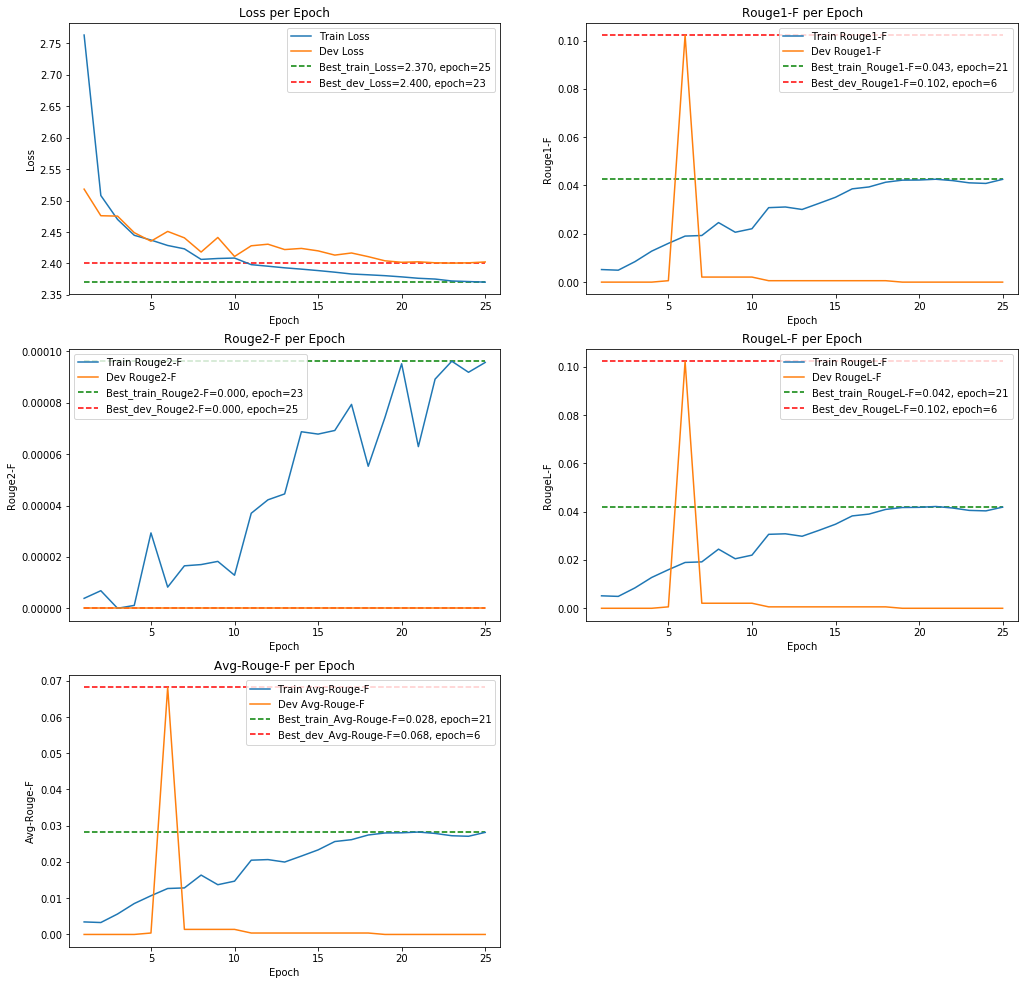

In [54]:
plot_train_dev_curves(mini_checkpoint['history'], nrows=3, ncols=2, figsize=(17, 17))

In [107]:
result = test_model(nmt, mini_checkpoint, criterion, mini_test_batches, use_best_dev_weights=True)

Testing with best_dev_wts ...
Batch: 4/4, running metrics: loss=2.45907, rouge1_f=0.10133, rouge2_f=0.00000, rougel_f=0.10133, elapsed_time=0m 2s
Test complete in 0m 2s
Test loss: 2.459071
Test rouge-1 f: 0.101334
Test rouge-2 f: 0.000000
Test rouge-l f: 0.101334
Test avg f: 0.067556


In [111]:
display_examples(clean_data, mini_test_titles, result['test_indices'], result['model_translations'], result['scores_list'],
                top_k=2, random_k=2, worst_k=0)

=========== TOP 2 translations ===============

******** top 1 (avg_rouge_f = 0.26667) *******
--- SOURCE:
 Add mustard seeds.
--- MODEL:
 aee the
--- GT:
 Heat the oil.

******** top 2 (avg_rouge_f = 0.26667) *******
--- SOURCE:
 You have successfully blocked Yahoo.com
--- MODEL:
 aee the
--- GT:
 Save the file.

=========== Random 2 translations ===============

******** random 1338 (avg_rouge_f = 0.00000) *******
--- SOURCE:
 You should register as soon as possible after starting your business. You should register no later than October 5 of your business’s second tax year.
--- MODEL:
 aee the
--- GT:
 Avoid delay.

******** random 1119 (avg_rouge_f = 0.00000) *******
--- SOURCE:
 It's in the top right corner of the screen. Doing so will add your card or pass to Wallet.
--- MODEL:
 aee the
--- GT:
 Tap Done.



## 2) Full-dataset: resultados

Spoiler: me fue horrible también :(

Básicamente corrí la misma suerte que con el mini dataset. El modelo la verdad no parece estar aprendiendo nada significativo. Mirándolo por el lado positivo sí, al menos todo el esfuerzo que metí en esto me sirvió para aprender **un montón** de pytorch, aprendí a programar el encoder del Transformer (aunque todavía me falta ver que funcione exitosamente) y también me dí cuenta de que diseñar un modelo para machine translation que opere a nivel de caracteres y palabras, con una función de pérdida buena que le permita realmente aprender bien la tarea, es algo nada de trivial. De hecho siento que me falta estudiar más papers de NLP donde se usen caracteres para tener una mejor idea de qué cosas se han hecho y que cosas pueden funcionar.

In [14]:
all_train_titles = load_pickle('./all_train_titles.pkl')
all_dev_titles = load_pickle('./all_dev_titles.pkl')
all_test_titles = load_pickle('./all_test_titles.pkl')
all_id2char = load_pickle('./all_id2char.pkl')
all_char2id = load_pickle('./all_char2id.pkl')

In [31]:
EPOCHS = 8
DECAY_PATIENCE = 0
LR_DECAY = 0.5
LR = 1e-3

CHAR_EMBEDDING_SIZE=64
WORD_EMBEDDING_SIZE=256
CHAR_TRANSFORMER_RECURRENT_STEPS=3
WORD_TRANSFORMER_RECURRENT_STEPS=5
CHAR_TRANSFORMER_HEADS=2
WORD_TRANSFORMER_HEADS=4
DECODER_HIDDEN_SIZE=256
DECODER_CHAR_PRED_HIDDEN_SIZE=64
DROPOUT_PROB = 0.04

MAX_BATCH_MEM = 1024**3 / 4

In [16]:
all_train_batches = precompute_batches(clean_data, all_train_titles, all_char2id,
                                        char_emb_size=CHAR_EMBEDDING_SIZE,
                                        word_emb_size=WORD_EMBEDDING_SIZE,
                                        max_batch_mem=MAX_BATCH_MEM)

100%|██████████| 191078/191078 [00:24<00:00, 7948.66it/s] 


In [17]:
all_dev_batches = precompute_batches(clean_data, all_dev_titles, all_char2id,
                                        char_emb_size=CHAR_EMBEDDING_SIZE,
                                        word_emb_size=WORD_EMBEDDING_SIZE,
                                        max_batch_mem=MAX_BATCH_MEM)

100%|██████████| 6100/6100 [00:00<00:00, 8067.57it/s] 


In [18]:
all_test_batches = precompute_batches(clean_data, all_test_titles, all_char2id,
                                        char_emb_size=CHAR_EMBEDDING_SIZE,
                                        word_emb_size=WORD_EMBEDDING_SIZE,
                                        max_batch_mem=MAX_BATCH_MEM)

100%|██████████| 6100/6100 [00:00<00:00, 8095.40it/s] 


In [19]:
nmt_full = NeuralMachineTranslator(
    char_vocab_size=len(all_char2id),
    char_embedding_size=CHAR_EMBEDDING_SIZE,
    word_embedding_size=WORD_EMBEDDING_SIZE,
    char_transformer_recurrent_steps=CHAR_TRANSFORMER_RECURRENT_STEPS,
    char_transformer_heads=CHAR_TRANSFORMER_HEADS,
    word_transformer_recurrent_steps=WORD_TRANSFORMER_RECURRENT_STEPS,
    word_transformer_heads=WORD_TRANSFORMER_HEADS,
    dec_hidden_size=DECODER_HIDDEN_SIZE,
    dec_char_pred_hidden_size=DECODER_CHAR_PRED_HIDDEN_SIZE,
    id2char=all_id2char,
    dropout=DROPOUT_PROB,
).to(DEVICE)

In [21]:
num_trainable_parameters(nmt_full)

1996507

In [22]:
optimizer = torch.optim.Adam(nmt_full.parameters(), lr=LR)

In [32]:
criterion = NMT_MultitaskLossCriterion(
    char_islast_pos_weight=3.0, word_islast_pos_weight=4.0,
    w_char_class=0.8, w_char_islast=0.1, w_word_islast=0.1,
)

In [25]:
scheduler = ReduceLROnPlateau(optimizer, factor=LR_DECAY, patience=DECAY_PATIENCE, mode='max', verbose=True)

In [33]:
ret = train_model(nmt_full, optimizer, criterion, scheduler,
            train_batches = all_train_batches,
            dev_batches = all_dev_batches,
            epochs = EPOCHS)

training from scratch ....

====== [Epoch 1/8]
--------------------- train ---------------------
Batch: 3192/3192, running metrics: loss=2.62773, rouge1_f=0.0032, rouge2_f=0.0000, rougel_f=0.0032, elapsed_time=14m 38s
	*** improvement detected! best_train_f=0.002103
--------------------- dev ---------------------
Batch: 103/103, running metrics: loss=2.60248, rouge1_f=0.0000, rouge2_f=0.0000, rougel_f=0.0000, elapsed_time=1m 22s
	*** [DEVSET] improvement detected! best_dev_f=0.000000

====== [Epoch 2/8]
--------------------- train ---------------------
Batch: 3192/3192, running metrics: loss=2.52785, rouge1_f=0.0001, rouge2_f=0.0000, rougel_f=0.0001, elapsed_time=14m 31s
--------------------- dev ---------------------
Batch: 103/103, running metrics: loss=2.57778, rouge1_f=0.0000, rouge2_f=0.0000, rougel_f=0.0000, elapsed_time=1m 11s
Epoch     1: reducing learning rate of group 0 to 5.0000e-04.

====== [Epoch 3/8]
--------------------- train ---------------------
Batch: 3192/3192, runn

In [36]:
torch.save(ret, './nmt-full.pth')

In [37]:
!du -h nmt-full.pth

28M	nmt-full.pth


In [38]:
full_checkpoint = torch.load('./nmt-full.pth')

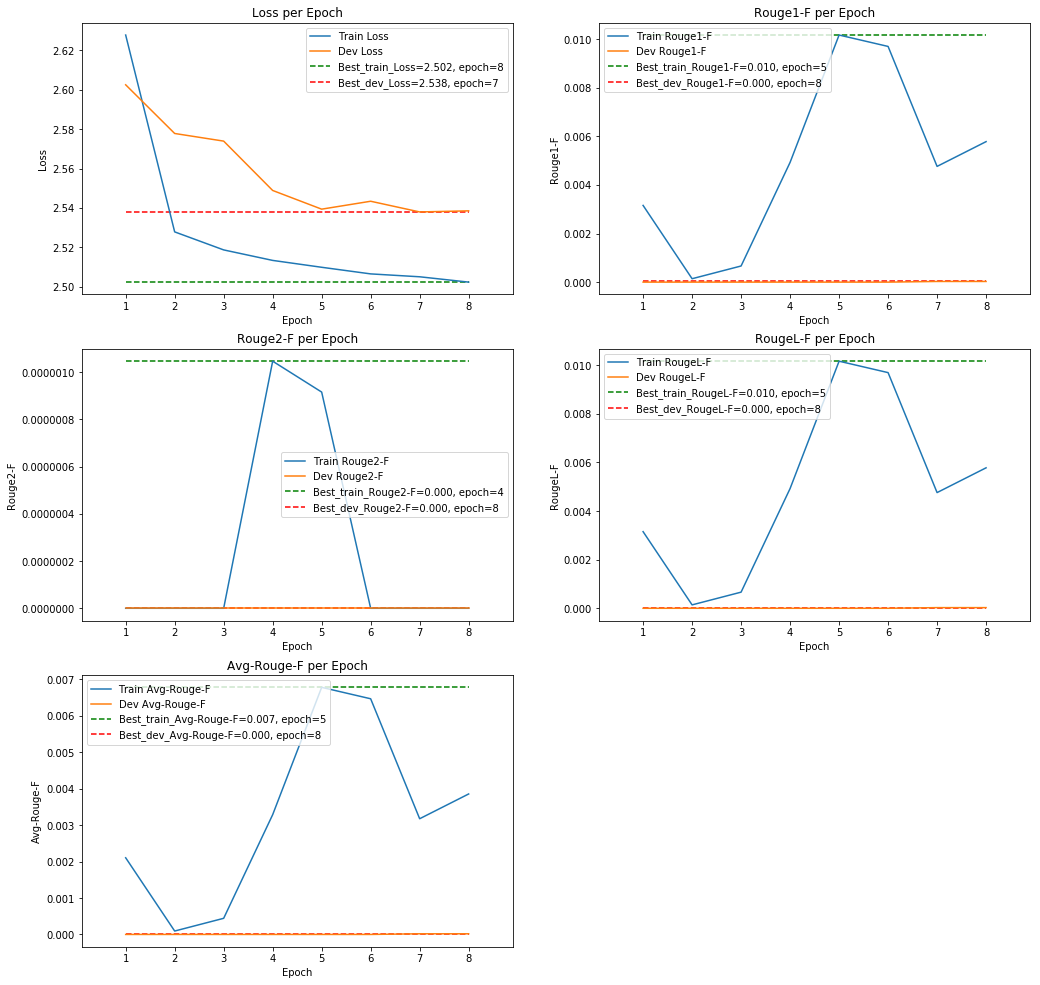

In [41]:
plot_train_dev_curves(full_checkpoint['history'], nrows=3, ncols=2, figsize=(17, 17))

In [39]:
result = test_model(nmt_full, full_checkpoint, criterion, all_test_batches, use_best_dev_weights=True)

Testing with best_dev_wts ...
Batch: 104/104, running metrics: loss=2.53601, rouge1_f=0.00014, rouge2_f=0.00000, rougel_f=0.00014, elapsed_time=0m 20s
Test complete in 0m 20s
Test loss: 2.536010
Test rouge-1 f: 0.000137
Test rouge-2 f: 0.000000
Test rouge-l f: 0.000137
Test avg f: 0.000091


In [40]:
display_examples(clean_data, all_test_titles, result['test_indices'], result['model_translations'], result['scores_list'],
                top_k=2, random_k=2, worst_k=0)

=========== TOP 2 translations ===============

******** top 1 (avg_rouge_f = 0.19048) *******
--- SOURCE:
 A fun and creative way to show your flexibility can be touching your toes, then stretch to your head in a seal stretch. Try your best and it could be fun for you!
--- MODEL:
 Coeeeee toe toeeeee
--- GT:
 Do some toe touches.

******** top 2 (avg_rouge_f = 0.19048) *******
--- SOURCE:
 Do not believe urban health myths such as rubbing coal on your toe to make an infection go away. Although some people swear by this method, the coal won’t benefit the infection or the ingrown nail at all. In fact, this method may make it worse. In general, you should not put anything on your toe or the infected area except for antibiotic cream or bandages.
--- MODEL:
 Coeeeee toe toeeeee
--- GT:
 Avoid coating your toe.

=========== Random 2 translations ===============

******** random 856 (avg_rouge_f = 0.00000) *******
--- SOURCE:
 Sync the ringtone with your iPhone on iTunes using a USB cable. Y